In [1]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline
#Constante para el tamño de las imagenes
rcParams['figure.figsize'] = (13, 6)

In [2]:
# 1. Cargar los datos para entrenamiento
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
train.set_window(end="30-4-2011")      # Usando como final el 30 de abril
train_elec = train.buildings[1].elec

In [3]:
from daedisaggregator import DAEDisaggregator
dae = DAEDisaggregator(256)

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [4]:
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['fridge'] # The microwave meter that is used as a training target

In [5]:
dae.train(train_mains, train_meter, epochs=2, sample_period=1)
dae.export_model("model-redd100.h5")

C:\Users\josel\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:446: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (3)
  sample_period, default_sample_period


Epoch 1/2
245/245 [==============================] - 11s 42ms/step - loss: 4.1325e-04
Epoch 2/2
245/245 [==============================] - 10s 41ms/step - loss: 3.6590e-04


In [6]:
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
test.set_window(start="30-4-2011")
test_elec = test.buildings[1].elec
test_mains = test_elec.mains().all_meters()[0]

# Crea un archivo hdf5. Claves ['/building1/elec/meter1', '/building1/elec/meter5']
# Contiene los grupos:
#[/building1/elec/meter1 (Group) ''
#   children := ['table' (Table)], /building1/elec/meter5 (Group) ''
#   children := ['table' (Table)]]


#disag_filename = 'disag-out.h5' # The filename of the resulting datastore
disag_filename = 'Prueba_out.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

In [7]:
# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
dae.disaggregate(test_mains, output, train_meter, sample_period=1)

New sensible chunk: 121482 size of data
New sensible chunk: 112661 size of data
New sensible chunk: 87770 size of data
New sensible chunk: 54084 size of data
New sensible chunk: 2660 size of data
New sensible chunk: 33513 size of data
New sensible chunk: 138535 size of data
New sensible chunk: 32514 size of data
New sensible chunk: 27255 size of data
New sensible chunk: 34833 size of data
New sensible chunk: 100831 size of data


In [8]:
dae.disaggregate?

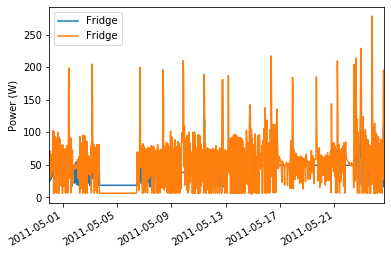

In [8]:
result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

In [8]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

============ Recall: 0.3692196783833122
============ Precision: 0.9493298938251147
============ Accuracy: 0.4751476958377115
============ F1 Score: 0.5316618888900848
============ Relative error in total energy: 0.6671692265211046
============ Mean absolute error(in Watts): 38.074252370842885


# Estructura propia

In [12]:
hdf = pd.HDFStore("Prueba_out.h5")

In [13]:
hdf.keys()

['/building1/elec/meter1', '/building1/elec/meter5']

In [14]:
hdf.items()

<generator object HDFStore.items at 0x00000243A63DDAF0>

In [15]:
hdf.groups()

[/building1/elec/meter1 (Group) ''
   children := ['table' (Table)], /building1/elec/meter5 (Group) ''
   children := ['table' (Table)]]

In [17]:
hdf.close()